# Conference Comparison Matrix
- create visualization of conference vs conference heatmap

## Setup - Men's Scores

In [95]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import datetime

# Store Date as MM/DD/YYYY
today = datetime.date.today()

### Set Default Plot Ratio and Size
set_fig_size = (8, 10)

## Set the color map
color_map = 'coolwarm'
# Try other color options
# color_map = 'YlGnBu'  # Choose a color map for the heatmap
# color_map = 'coolwarm'
# color_map = 'viridis'

##############################################

# Load Schedult/results data and compare conferences
path = os.path.join('..', 'data', 'schedule', 'Week 1 Scores.csv')
# Load the data
schedule_df = pd.read_csv(path)

# Define logo folder path
mens_logo_folder = os.path.join('..', 'images', 'logos', 'conference')

# filter out exhibition games
schedule_df = schedule_df[schedule_df['Conference'] != 'Exhibition']
# Clean up Team names (remove ' and periods)
schedule_df['Away_Team'] = schedule_df['Away_Team'].str.replace("'", "").str.replace(".", "")
schedule_df['Home_Team'] = schedule_df['Home_Team'].str.replace("'", "").str.replace(".", "")
# strip leading and trailing spaces
schedule_df['Away_Team'] = schedule_df['Away_Team'].str.strip()
schedule_df['Home_Team'] = schedule_df['Home_Team'].str.strip()
# Drop any rows containing a / or TBD
schedule_df = schedule_df[~schedule_df['Away_Team'].str.contains('/')]
schedule_df = schedule_df[~schedule_df['Home_Team'].str.contains('/')]
schedule_df = schedule_df[~schedule_df['Away_Team'].str.contains('TBD')]
schedule_df = schedule_df[~schedule_df['Home_Team'].str.contains('TBD')]

# Only Consider games designated Non-Conference
### This will miss a few special event / nueutral site games like the Ice Breaker
# schedule_df = schedule_df[schedule_df['Conference'] == 'Non-Conference']


# whitelist contains [Ice Breaker, ]


## Men's D1

#### Backend

In [96]:
# Define the conferences
conference_teams = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']
}



In [97]:
# Function to get the conference of a team
def get_conference(team):
    for conference, teams in conference_teams.items():
        if team in teams:
            return conference
    return 'Unknown'  # For teams not in the provided lists

# Add columns for conference of both the away and home teams
schedule_df['Away_Conference'] = schedule_df['Away_Team'].apply(get_conference)
schedule_df['Home_Conference'] = schedule_df['Home_Team'].apply(get_conference)

# Drop rows with Unknown conferences - Stonehill and Long Island annonmaly
schedule_df = schedule_df[schedule_df['Away_Conference'] != 'Unknown']
schedule_df = schedule_df[schedule_df['Home_Conference'] != 'Unknown']

################# OUTPUT SCHEDULE_DF TO TEMP FOLDER FOR INSPECT
# schedule_df.to_csv(os.path.join('..', 'TEMP', 'schedule_df.csv'), index=False)
####################################################

# Rename to completed_games_df
completed_games_df = schedule_df

# Filter out only non-conference games
non_conference_games = schedule_df[schedule_df['Away_Conference'] != schedule_df['Home_Conference']]

# Create a list of unique conferences for indexing the matrix
conferences = list(set(non_conference_games['Away_Conference'].unique()).union(set(non_conference_games['Home_Conference'].unique())))

# Initialize an empty matrix with zeros
out_of_conference_matrix = pd.DataFrame(0, index=conferences, columns=conferences)

# Iterate over non-conference games to populate the matrix
for _, row in non_conference_games.iterrows():
    # Determine the winning and losing conference
    if row['Away_Score'] > row['Home_Score']:
        winning_conference = row['Away_Conference']
        losing_conference = row['Home_Conference']
    elif row['Home_Score'] > row['Away_Score']:
        winning_conference = row['Home_Conference']
        losing_conference = row['Away_Conference']
    else:
        # Skip ties for now
        continue

    # Increment the win count for the winning conference against the losing conference
    out_of_conference_matrix.loc[winning_conference, losing_conference] += 1

# Sort rows and columns alphabetically
out_of_conference_matrix = out_of_conference_matrix.sort_index(axis=0).sort_index(axis=1)


# Calculate wins by summing across rows (wins for each conference against others)
overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# Calculate losses by summing across columns (losses against each conference)
overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

### Find Out of Conference Ties, tally them and store as a seperate series to create the overall record
# Step 1: Calculate Ties for Each Conference
# Filter non-conference games and count ties
overall_out_of_conference_ties = pd.Series(0, index=conferences)

for _, row in non_conference_games.iterrows():
    if row['Away_Score'] == row['Home_Score']:
        # Increment ties for both the away and home conferences
        overall_out_of_conference_ties[row['Away_Conference']] += 1
        overall_out_of_conference_ties[row['Home_Conference']] += 1

# Step 2: Update Overall Record with Wins, Losses, and Ties
overall_record = (
    overall_out_of_conference_wins.astype(int).astype(str) + ' - ' +
    overall_out_of_conference_losses.astype(int).astype(str) + ' - ' +
    overall_out_of_conference_ties.astype(int).astype(str)
)

# print(overall_record)

#### Output Viz

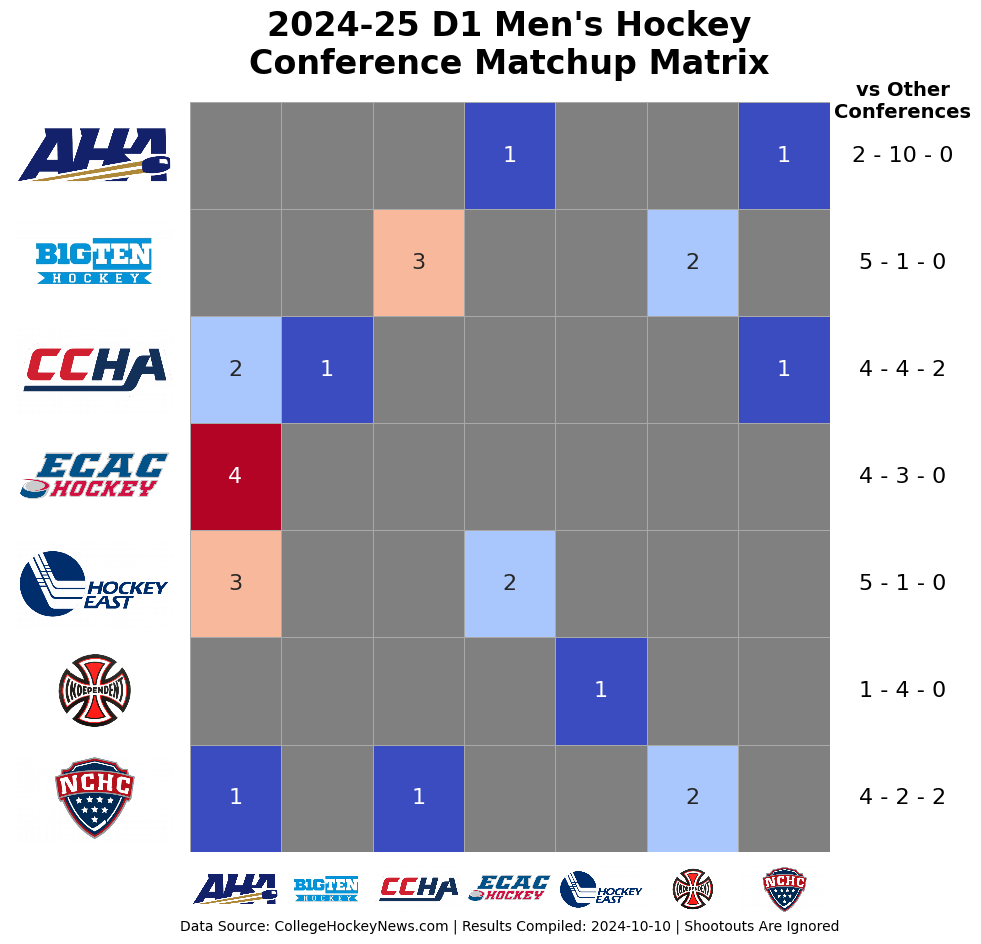

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os



# Create the heatmap
plt.figure(figsize=(set_fig_size))  # Increase figure width for more space on the right side

# Create a new mask that matches the shape of the out_of_conference_matrix
mask = out_of_conference_matrix == 0

# Plot the heatmap without zero values (masked)
ax = sns.heatmap(out_of_conference_matrix,
                 annot=True, fmt='d', 
                 cmap=color_map, linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask,  # Mask the zero values
                 annot_kws={"size": 16})  # Adjust annotation font size

# Overlay only the zero cells with a gray color
ax.pcolormesh(np.where(mask, 1, np.nan), cmap=ListedColormap(['gray']), edgecolors='darkgray', linewidth=0.5)

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)  # Increase right to 0.95

# Add the overall record (win-loss-tie format) to the right side of the heatmap
for idx, label in enumerate(overall_record):
    # Adjust horizontal alignment and position for better visibility
    ax.text(out_of_conference_matrix.shape[1] + 0.8, idx + 0.5,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black')

# Add label for the overall record column above the annotations
ax.text(out_of_conference_matrix.shape[1] + 0.8, 0, "vs Other\nConferences",
        va='center', ha='center', fontsize=14, color='black', weight='bold')

# Load conference logos
conference_logo_mapping = {
    'Atlantic': 'atlantic.png',
    'Big Ten': 'big_ten.png',
    'CCHA': 'ccha.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NCHC': 'nchc.png',
    'Independents': 'independent_scaled.png'
}
# Add conference logos as x-tick and y-tick labels
def add_logo_to_axis(axis, axis_labels, is_xtick=True):
    for idx, label in enumerate(axis_labels):
        logo_path = os.path.join(mens_logo_folder, conference_logo_mapping[label])
        if os.path.exists(logo_path):
            img = plt.imread(logo_path)
            zoom_level = 0.125 if is_xtick else 0.225  # Adjust zoom for x and y axis logos
            imagebox = OffsetImage(img, zoom=zoom_level)  # Adjust zoom for logo size to fit properly
            if is_xtick:
                ab = AnnotationBbox(imagebox, (idx + 0.5, -0.05),  # Adjust position to fit below x-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('data', 'axes fraction'))
            else:
                ab = AnnotationBbox(imagebox, (-0.15, idx + 0.5),  # Adjust position to fit left of y-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('axes fraction', 'data'))
            axis.add_artist(ab)

# Add logos for x and y axes
add_logo_to_axis(ax, out_of_conference_matrix.columns, is_xtick=True)
add_logo_to_axis(ax, out_of_conference_matrix.index, is_xtick=False)

# Add labels and titles outside of the logos
ax.set_ylabel('')
ax.set_xlabel('')
# Remove default x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
# Remove x and y tick marks
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

### NOT NESS, DON'T LIKE LOOK
# # Add Winning Conference label above y axis logos
# ax.text(out_of_conference_matrix.shape[1] - 8.2, 7.1, "Winning\nConference", va='center', ha='center', fontsize=12, weight='bold', color='black')

plt.title("2024-25 D1 Men's Hockey\nConference Matchup Matrix", fontdict={'fontsize': 24}, weight='bold', pad=20)

# Add text for data annotation ( Data Source & Date) to bottom of image
plt.text(0.5, -0.1, f'Data Source: CollegeHockeyNews.com | Results Compiled: {today} | Shootouts Are Ignored', ha='center', va='center', 
        fontsize=10, transform=ax.transAxes)

# Invert the y-axis to match the conference hierarchy
# plt.gca().invert_yaxis()

# Show the plot
plt.show()


##### ORIGNIAL NO LOGO MATRIX

In [99]:
# ###### ORINAL WORKING CODE #######

# # Assuming you already have your 'total_wins_matrix' and 'out_of_conference_matrix' ready
# color_map = 'YlGnBu'  # Choose a color map for the heatmap

# # Calculate the overall out-of-conference wins for each conference
# overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# # Calculate the total losses (opponent wins) for each conference
# overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

# # Prepare the win-loss record in "wins - losses" format
# overall_record = overall_out_of_conference_wins.astype(int).astype(str) + ' - ' + overall_out_of_conference_losses.astype(int).astype(str)

# # Mask 0s in the matrix
# mask = out_of_conference_matrix == 0

# # Create the heatmap
# plt.figure(figsize=(8, 10))

# # Plot the heatmap without zero values (masked)
# ax = sns.heatmap(out_of_conference_matrix,
#                  annot=True, fmt='d', 
#                  cmap=color_map, linewidths=.5, 
#                  cbar=False,  # Remove the color bar
#                  mask=mask,  # Mask the zero values
#                  annot_kws={"size": 16})  # Adjust annotation font size


# # Overlay only the zero cells with a gray color
# ax.pcolormesh(np.where(mask, 1, np.nan), cmap=ListedColormap(['gray']), edgecolors='darkgray', linewidth=0.5)

# # Add space on the right side to fit the overall record annotations
# plt.subplots_adjust(right=0.85)

# # Add the overall record (win-loss format) to the right side of the heatmap
# for idx, label in enumerate(overall_record):
#     # Position the text to the right of the heatmap
#     ax.text(out_of_conference_matrix.shape[1] + 0.2, idx + 0.5,  # Adjust horizontal and vertical alignment
#             label, va='center', ha='left', fontsize=12, color='black')

# # Add labels and titles
# ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16})
# ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16})
# plt.title("D1 Men's Hockey\nConference vs Conference Matrix", fontdict={'fontsize': 24})

# # Invert the y-axis to match the conference hierarchy
# plt.gca().invert_yaxis()

# # Show the plot
# plt.show()

## Women's Plot 
- 

#### Get Results Table from CHN

In [100]:
from bs4 import BeautifulSoup
import requests
import re

# url of CHN woman's results page - Only includes results from Oct 1 on - need to manually get and add September games
urls = ['https://www.collegehockeynews.com/women/schedule.php?date=20240920', 
        'https://www.collegehockeynews.com/women/schedule.php?date=20240927', 
        'https://www.collegehockeynews.com/women/schedule.php?season=20242025']

# url = 'https://www.collegehockeynews.com/women/schedule.php?season=20242025'

def get_game_data(url):
    # Get the page with requests
    response = requests.get(url)

    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')

    # select the table or tables
    tables = soup.find_all('table')

    # Initialize variables
    current_date = None
    current_conference = None
    game_notes = None

    # Initialize an empty list to hold the data
    data = []

    # Parse the table with BeautifulSoup

    rows = soup.find_all('tr')

    # Loop through each row to find relevant information
    for row in rows:
        # Check for date row
        if row.get('class') == ['stats-section']:
            current_date = row.find('td').text.strip()
        # Check for conference row
        elif row.get('class') == ['sked-header']:
            current_conference = row.find('td').text.strip()
        # Check for game notes
        elif len(row.find_all('td')) == 2:
            game_notes = row.find_all('td')[1].text.strip()
        # Process rows with game data
        elif row.get('valign') == 'top':
            cells = row.find_all('td')
            if len(cells) >= 9:
                home_team = cells[0].text.strip()
                home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
                home_score = cells[1].text.strip()
                away_team = cells[3].text.strip()
                away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
                away_score = cells[4].text.strip()
                ot = cells[5].text.strip()
                box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
                metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
                # Capture Game Notes
                game_notes_cell = cells[-1].find('small')
                game_notes = game_notes_cell.text.strip() if game_notes_cell else None

                # Append data to the list
                data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
                game_notes = None  # Reset game notes for the next row

    return data

# Initialize an empty list to hold all the data
data = []

# loop through all the urls
for url in urls:
    data += get_game_data(url)
                


# Create a DataFrame
columns = ['Date', 'Conference', 'Game_Notes', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'Home_Team', 'Home_Team_Link', 'Home_Score',  'OT', 'Box_Link', 'Metrics_Link']
df = pd.DataFrame(data, columns=columns)

# # Clean Team names for ease of use (remove any dashes, ' or periods)
df['Away_Team'] = df['Away_Team'].str.replace("'", "").str.replace(".", "").str.replace("-", " ")
df['Home_Team'] = df['Home_Team'].str.replace("'", "").str.replace(".", "").str.replace("-", " ")

print('Original Length:', len(df))

# Drop any duplicate rows
df.drop_duplicates(inplace=True)

print('After Dropping Duplicates:', len(df))

# Drop Exhibition games
df = df[~df['Conference'].str.contains('Exhibition')]

print('After Dropping Exhibition Games:', len(df))

# Drop rows with / in either team name
df = df[~df['Away_Team'].str.contains('/')]
df = df[~df['Home_Team'].str.contains('/')]

print('After Dropping Teams with /:', len(df))
df.head(5)
# Rename to w_results_df
w_results_df = df
schedule_df = df

Original Length: 781
After Dropping Duplicates: 751
After Dropping Exhibition Games: 739
After Dropping Teams with /: 723


#### Back End

In [101]:
### Conference Membersip - Women's D1

w_atlantic = ['Lindenwood', 'Mercyhurst', 'Penn State', 
            'RIT', 'Robert Morris', 'Syracuse']

w_ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']


w_hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Holy Cross', 
                'Maine', 'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

w_newha = ['Assumption', 'Franklin Pierce', 'Long Island', 'Post', 'Sacred Heart',
        'Saint Anselm', 'Saint Michaels', 'Stonehill']

w_wcha = ['Bemidji State', 'Minnesota', 'Minnesota Duluth', 'Minnesota State', 'Ohio State', 
            'St Cloud State', 'St Thomas', 'Wisconsin']

# Create dictionary of conferences and their teams

w_conference_teams = {
    'Atlantic': w_atlantic,
    'ECAC': w_ecac,
    'Hockey East': w_hockey_east,
    'NewHA': w_newha,
    'WCHA': w_wcha
}

In [102]:
# Function to get the conference of a team
def get_conference(team):
    for conference, teams in w_conference_teams.items():
        if team in teams:
            return conference
    return 'Unknown'  # For teams not in the provided lists

# Add columns for conference of both the away and home teams
schedule_df['Away_Conference'] = schedule_df['Away_Team'].apply(get_conference)
schedule_df['Home_Conference'] = schedule_df['Home_Team'].apply(get_conference)

# Drop rows with Unknown conferences - Stonehill and Long Island annonmaly
schedule_df = schedule_df[schedule_df['Away_Conference'] != 'Unknown']
schedule_df = schedule_df[schedule_df['Home_Conference'] != 'Unknown']

# Remove any games that haven't been played yet (no value in home or away score
schedule_df = schedule_df[(schedule_df['Home_Score'] != '') & (schedule_df['Away_Score'] != '')]


################# OUTPUT SCHEDULE_DF TO TEMP FOLDER FOR INSPECT
# schedule_df.to_csv(os.path.join('..', 'TEMP', 'schedule_df.csv'), index=False)
####################################################

# Rename to completed_games_df
completed_games_df = schedule_df

# Filter out only non-conference games
non_conference_games = completed_games_df[completed_games_df['Away_Conference'] != completed_games_df['Home_Conference']]

# Create a list of unique conferences for indexing the matrix
conferences = list(set(non_conference_games['Away_Conference'].unique()).union(set(non_conference_games['Home_Conference'].unique())))

# Initialize an empty matrix with zeros
out_of_conference_matrix = pd.DataFrame(0, index=conferences, columns=conferences)

# Iterate over non-conference games to populate the matrix
for _, row in non_conference_games.iterrows():
    # Determine the winning and losing conference
    if row['Away_Score'] > row['Home_Score']:
        winning_conference = row['Away_Conference']
        losing_conference = row['Home_Conference']
    elif row['Home_Score'] > row['Away_Score']:
        winning_conference = row['Home_Conference']
        losing_conference = row['Away_Conference']
    else:
        # Skip ties for now
        continue

    # Increment the win count for the winning conference against the losing conference
    out_of_conference_matrix.loc[winning_conference, losing_conference] += 1

# Sort rows and columns alphabetically
out_of_conference_matrix = out_of_conference_matrix.sort_index(axis=0).sort_index(axis=1)


# Calculate wins by summing across rows (wins for each conference against others)
overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# Calculate losses by summing across columns (losses against each conference)
overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

### Find Out of Conference Ties, tally them and store as a seperate series to create the overall record
# Step 1: Calculate Ties for Each Conference
# Filter non-conference games and count ties
overall_out_of_conference_ties = pd.Series(0, index=conferences)

for _, row in non_conference_games.iterrows():
    if row['Away_Score'] == row['Home_Score']:
        # Increment ties for both the away and home conferences
        overall_out_of_conference_ties[row['Away_Conference']] += 1
        overall_out_of_conference_ties[row['Home_Conference']] += 1

# Step 2: Update Overall Record with Wins, Losses, and Ties
overall_record = (
    overall_out_of_conference_wins.astype(int).astype(str) + ' - ' +
    overall_out_of_conference_losses.astype(int).astype(str) + ' - ' +
    overall_out_of_conference_ties.astype(int).astype(str)
)

print(overall_record)

Atlantic       11 - 12 - 0
ECAC            16 - 9 - 0
Hockey East    10 - 16 - 1
NewHA           1 - 17 - 1
WCHA            19 - 3 - 0
dtype: object


In [103]:
## Save results table to csv for inspection 
# w_results_df.to_csv('../TEMP/w_results_df.csv')

#### Output Women's D1 Plot

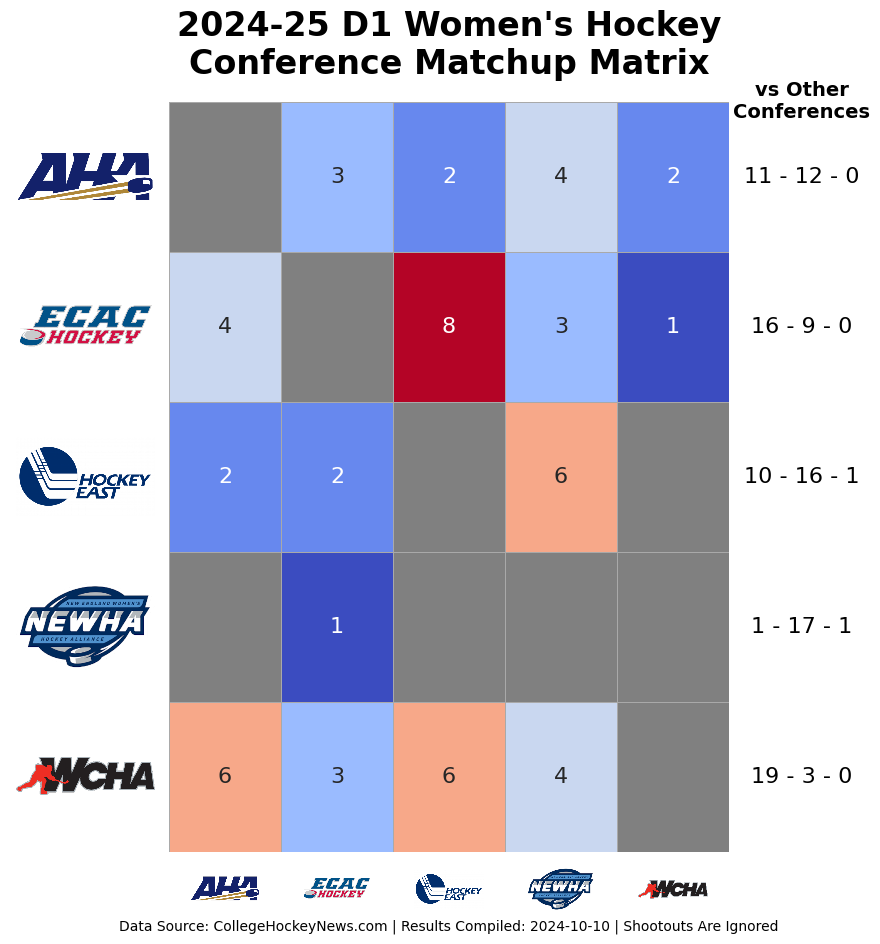

In [104]:
# import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os



# Mask 0s in the matrix
mask = out_of_conference_matrix == 0

# Create the heatmap
plt.figure(figsize=(8, 10))

# Plot the heatmap without zero values (masked)
ax = sns.heatmap(out_of_conference_matrix,
                 annot=True, fmt='d', 
                 cmap=color_map, linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask,  # Mask the zero values
                 annot_kws={"size": 16})  # Adjust annotation font size

# Overlay only the zero cells with a gray color
ax.pcolormesh(np.where(mask, 1, np.nan), cmap=ListedColormap(['gray']), edgecolors='darkgray', linewidth=0.5)

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)

# Add the overall record (win-loss-tie format) to the right side of the heatmap
for idx, label in enumerate(overall_record):
    # Adjust horizontal alignment and position for better visibility
    ax.text(out_of_conference_matrix.shape[1] + 0.65, idx + 0.5,  # Bring labels closer by reducing offset
            label, va='center', ha='center', fontsize=16, color='black')

# Add label for the overall record column above the annotations
ax.text(out_of_conference_matrix.shape[1] + 0.65, 0, "vs Other\nConferences",
        va='center', ha='center', fontsize=14, color='black', weight='bold')


# Load conference logos
conference_logo_mapping = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}


# Add conference logos as x-tick and y-tick labels
def add_logo_to_axis(axis, axis_labels, is_xtick=True):
    for idx, label in enumerate(axis_labels):
        logo_path = os.path.join(mens_logo_folder, conference_logo_mapping[label])
        if os.path.exists(logo_path):
            img = plt.imread(logo_path)
            zoom_level = 0.10 if is_xtick else 0.20  # Adjust zoom for x and y axis logos
            imagebox = OffsetImage(img, zoom=zoom_level)  # Adjust zoom for logo size to fit properly
            if is_xtick:
                ab = AnnotationBbox(imagebox, (idx + 0.5, -0.05),  # Adjust position to fit below x-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('data', 'axes fraction'))
            else:
                ab = AnnotationBbox(imagebox, (-0.15, idx + 0.5),  # Adjust position to fit left of y-axis
                                   frameon=False, box_alignment=(0.5, 0.5),
                                   xycoords=('axes fraction', 'data'))
            axis.add_artist(ab)



# Add logos for x and y axes
add_logo_to_axis(ax, out_of_conference_matrix.columns, is_xtick=True)
add_logo_to_axis(ax, out_of_conference_matrix.index, is_xtick=False)

# Add labels and titles outside of the logos
# ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16}, labelpad=50)
# ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16}, labelpad=115)
ax.set_ylabel('')
ax.set_xlabel('')
# Remove default x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
# Remove x and y tick marks
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)


plt.title("2024-25 D1 Women's Hockey\nConference Matchup Matrix", fontdict={'fontsize': 24}, weight='bold', pad=20)

plt.text(0.5, -0.1, f'Data Source: CollegeHockeyNews.com | Results Compiled: {today} | Shootouts Are Ignored', ha='center', va='center', 
        fontsize=10, transform=ax.transAxes)


# Invert the y-axis to match the conference hierarchy
# plt.gca().invert_yaxis()
# Invert the x-axis to match the conference hierarchy
# plt.gca().invert_xaxis()

# Show the plot
plt.show()